## Forecasting energy demands using univariate time series analysis



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

# Loading data
Data source: Kaggle - https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
url = 'https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch11/DOM_hourly.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0
...,...,...
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0


# Generating daily data

In [5]:
# uncomment the following line for generating daily data
#df = df[df['Datetime'].str.contains("00:00:00")]

In [6]:
df['Datetime'] = pd.to_datetime(df.Datetime , format = '%Y-%m-%d %H:%M:%S')
df.index = df.Datetime
df.drop(['Datetime'], axis=1,inplace = True)

In [7]:
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [8]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0
...,...
2018-01-01 20:00:00,18418.0
2018-01-01 21:00:00,18567.0
2018-01-01 22:00:00,18307.0


In [9]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

# Examine data trend

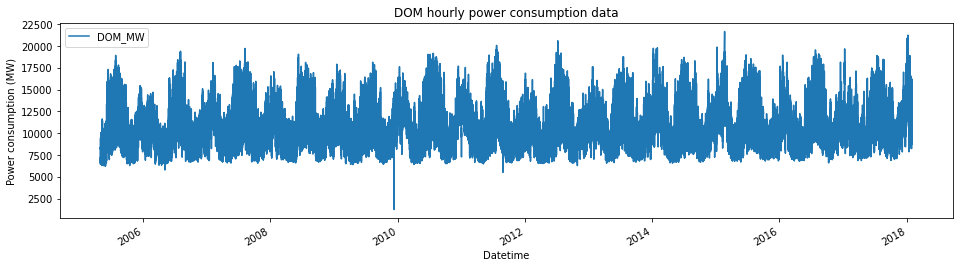

In [10]:
#@title Date Range
a = '2005-01-31' #@param {type:"date"}
b = '2018-01-31' #@param {type:"date"}

a = a + " 00:00:00" 
b = b + " 00:00:00"
df.loc[a:b].plot(figsize=(16,4),legend = True)

plt.title('DOM hourly power consumption data')
plt.ylabel('Power consumption (MW)')

plt.show() 

## Normalize the Data
Before proceeding with further data analysis we must ensure that the data is normalized.<br>
For this we will be using sklearn MinMaxScaler

In [11]:
df.shape

(116189, 1)

In [12]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))

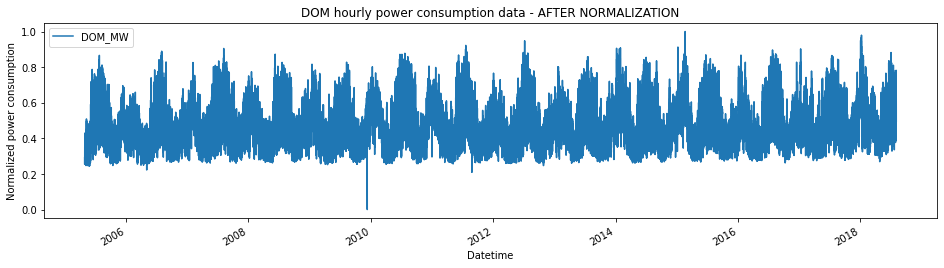

In [13]:
df.plot(figsize = (16,4), legend = True)
plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')
plt.ylabel('Normalized power consumption')
plt.show()

# Training/Testing datasets

In [14]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[int(0.9*(len(stock))):]             
    y_test = y_train[int(0.9*(len(stock))):]
    
    X_train = X_train[:int(0.9*(len(stock)))]           
    y_train = y_train[:int(0.9*(len(stock)))]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [15]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (104570, 20, 1)
y_train.shape =  (104570,)
X_test.shape =  (11599, 20, 1)
y_test.shape =  (11599,)


# Create input tensors

In [16]:
batch_size  = 256
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat() 

# Build model

In [17]:
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

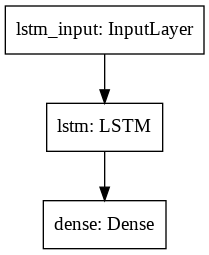

In [18]:
tf.keras.utils.plot_model(rnn_model)

# Compiling and training

In [19]:
rnn_model.compile(optimizer = 'adam', loss = 'mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10
rnn_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=test_data, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1032 - val_loss: 0.0725
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0646 - val_loss: 0.0635
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0575 - val_loss: 0.0582
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0510 - val_loss: 0.0504
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0444 - val_loss: 0.0425
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0357 - val_loss: 0.0330
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0270 - val_loss: 0.0235
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0245 - val_loss: 0.0259
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0218 - val_loss: 0.0201
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0192 - val_loss: 0.0171

# Prediction

In [20]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = "+"{:.4f}".format(rnn_score));

R2 Score of RNN model = 0.9571


## Plot of actual v/s predicted values
We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

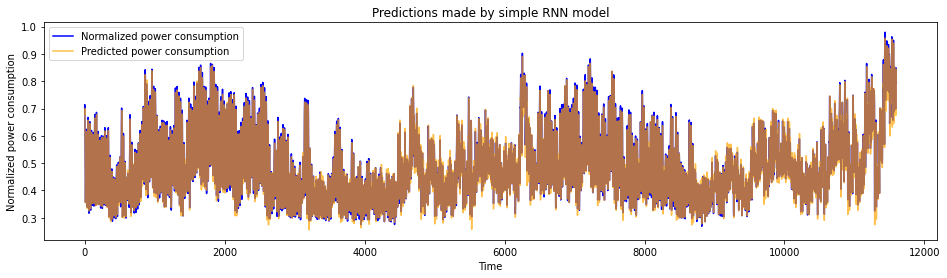

In [21]:
#@title Data Range
a = 0 #@param {type:"slider", min:0, max:12000, step:1}
b = 12000 #@param {type:"slider", min:0, max:12000, step:1}
 
def plot_predictions(test, predicted, title):
   plt.figure(figsize=(16,4))
   plt.plot(test[a:b], color='blue',label='Normalized power consumption')
   plt.plot(predicted[a:b], alpha=0.7, color='orange',label='Predicted power consumption')
   plt.title(title)
   plt.xlabel('Time')
   plt.ylabel('Normalized power consumption')
   plt.legend()
   plt.show()
  
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")


# Zooming in mid range

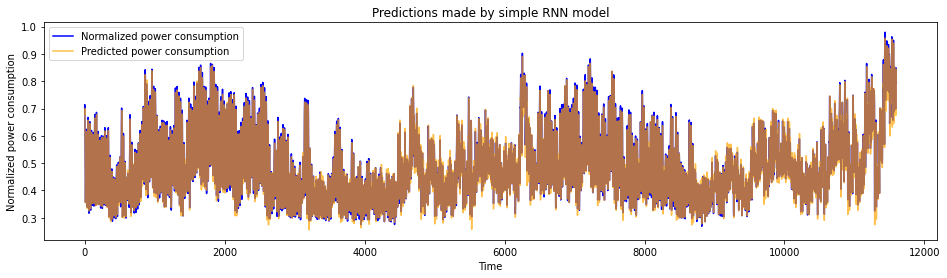

In [22]:
#@title Data Range
a = 0 #@param {type:"slider", min:0, max:12000, step:1}
b = 12000 #@param {type:"slider", min:0, max:12000, step:1}
 
def plot_predictions(test, predicted, title):
   plt.figure(figsize=(16,4))
   plt.plot(test[a:b], color='blue',label='Normalized power consumption')
   plt.plot(predicted[a:b], alpha=0.7, color='orange',label='Predicted power consumption')
   plt.title(title)
   plt.xlabel('Time')
   plt.ylabel('Normalized power consumption')
   plt.legend()
   plt.show()
  
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# Zooming in towards the end

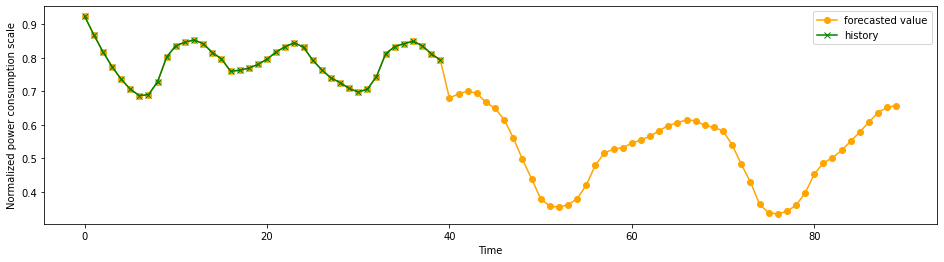

In [23]:
history_data = list(y_test[-40:])
plottingvalues = list(history_data)+list(rnn_predictions[:50])
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
plt.plot(y_test[-40:], color='green',label='history',marker='x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# Predicting next data point

In [24]:
X = X_test[-1:]

In [25]:
rnn_predictions1 = rnn_model.predict(X)

In [26]:
rnn_predictions1

array([[0.79906416]], dtype=float32)

In [27]:
history_data = list(y_test[-40:]) 

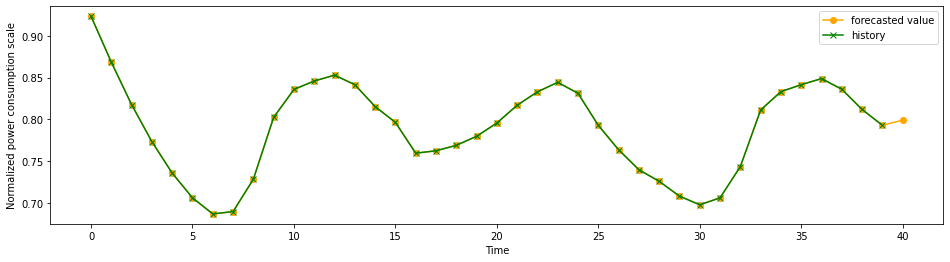

In [28]:
plottingvalues = list(history_data)+list(rnn_predictions1)
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
plt.plot(y_test[-40:], color='green',label='history',marker='x')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

## prediction for the range of dates

In [29]:
history_data = list(y_test[-40:])

In [30]:
def make_data(X,rnn_predictions1):
  val = list(X[0][1:])+list(rnn_predictions1)
  X_new = []
  X_new.append(list(val))
  X_new = np.array(X_new)
  return X_new

In [31]:
forecast = list()

In [32]:
X = X_test[-1:]

In [33]:
for i in range (25):
  X = make_data(X,rnn_predictions1)
  rnn_predictions1 = rnn_model.predict(X)
  forecast += list(rnn_predictions1)

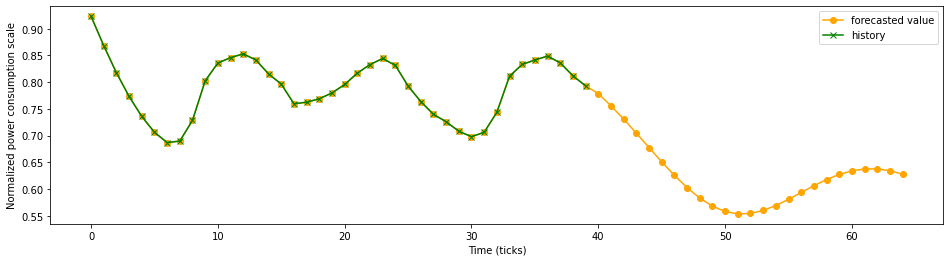

In [34]:
plottingvalues = list(history_data)+list(forecast)
plt.figure(figsize=(16,4))
plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
plt.plot(y_test[-40:], color='green',label='history',marker='x')
plt.xlabel('Time (ticks)')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()